In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
%matplotlib inline

##Import Reference Data

In [83]:
df_R = pd.read_csv(filepath_or_buffer = 'data/CompleteCal_shift.csv', parse_dates = [0], index_col = 0)
print df_R[:5]

                     CO_ppm  NO_ppb  NO2_ppb  O3_ppb
Date                                                
2014-07-07 07:13:00     0.2     1.1     13.4      28
2014-07-07 07:14:00     0.3     1.2     13.8      28
2014-07-07 07:15:00     0.3     1.2     14.4      26
2014-07-07 07:16:00     0.3     1.3     14.9      25
2014-07-07 07:17:00     0.3     7.8     17.9      24


##Import Pod Data

In [84]:
df_P = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D6_clean.csv', parse_dates = [0], index_col = 0)
print df_P[:5]

                       UnixTime  e2v03  Temp    Rh
YYYY/MM/DD_HH:MM:SS                               
2014-07-13 01:00:10  1405213210    109  27.7  33.9
2014-07-13 01:00:31  1405213231    109  27.7  33.9
2014-07-13 01:00:51  1405213251    108  27.7  33.9
2014-07-13 01:01:12  1405213272    107  27.7  33.9
2014-07-13 01:01:33  1405213293    110  27.7  33.9


###Resample all of the data, so that the reference, pod, and solar data are in the same dataframe, and also average over a specified time.

In [85]:
resamp_time = '1Min'

In [86]:
df_all = pd.concat([df_R.O3_ppb.resample(resamp_time), df_P.resample(resamp_time)], axis=1).dropna()
print df_all[:5]

                     O3_ppb      UnixTime       e2v03  Temp         Rh
Date                                                                  
2014-07-13 01:00:00      42  1.405213e+09  108.666667  27.7  33.900000
2014-07-13 01:01:00      38  1.405213e+09  110.000000  27.7  33.933333
2014-07-13 01:02:00      32  1.405213e+09  116.666667  27.7  34.133333
2014-07-13 01:03:00      31  1.405213e+09  119.666667  27.7  34.233333
2014-07-13 01:04:00      36  1.405213e+09  114.000000  27.7  34.133333


####Create 'days since start' feature.

In [87]:
df_all['days from start'] = df_all['UnixTime']
for i in range(0,len(df_all['UnixTime'])):
    df_all['days from start'][i] = int(df_all['UnixTime'][i]- df_all['UnixTime'][0])/86400

####Drop the names from all of the data to prepare it for filtering

In [88]:
df_fit = df_all.dropna()

In [89]:
rh_sm = None
temp_sm = None
ref_o3_sm = None
pod_o3_sm = None

#Declare the data column to filter.

#Filtering

####Define functions to plot the raw and filtered data

In [90]:
def plot_data(data, title):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    ax.plot(data, marker = '.')
    ax.set_title(title)

####Define a function that filters the data.

In [91]:
def plot_filter(b):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = ax1.twinx()

    w, h = signal.freqz(b)
    w /= np.pi
    ax1.plot(w, 20 * np.log10(abs(h)), 'r-')
    ax2.plot(w[1:], -np.diff(np.unwrap(np.angle(h))), 'b-')
    ax2.set_ylim(bottom=0.)

    ax3 = fig.add_subplot(212)
    ax3.plot(w, 20 * abs(h), 'r-')

In [92]:
def hanning_window_fir_filtering(data_points, filter_minutes, y_data):
    #make a window (finite-impulse response method), 
    #second agrment is frequency in units where 1 is sampling frequency (1 means 1 cycle per minute, 0.2 is equal to a period of 5 minutes) 
    #first agrument is how many data points are in the window (frequency resolution) if you choose 100, there is a time delay by 50 data points
    samp_freq = 1.0/filter_minutes
    b = signal.firwin(data_points, samp_freq, window='hanning')
    
    impulse = np.zeros((100,))
    impulse[0] = 1.

    #replace impulse with my y values
    y = signal.lfilter(b, 1., y_data)
    
    #call the plotting functions for the filtered and raw data.
    plot_data(y_data,'Raw Data')
    plot_data(y,'Filtered Data')    
    
    #Call the impulse plotting function
    plot_filter(b)
    
    #Delete the shifted points from the new data
    y_final = np.delete(y, list(xrange(data_points)))
    
    return y_final

####Call the filtering function

Reference Data
[ 42.34244559  41.99037286  41.29561376  40.32717166  39.21467687
  38.127986    37.242697    36.70098431  36.57885256  36.86953104
  37.48802083  38.29536902  39.13555245  39.87433613  40.4294821
  40.78452703  40.98322801  41.10733388  41.24479247  41.4578178
  41.76002097  42.10908948  42.41694705  42.57461769  42.48487448]


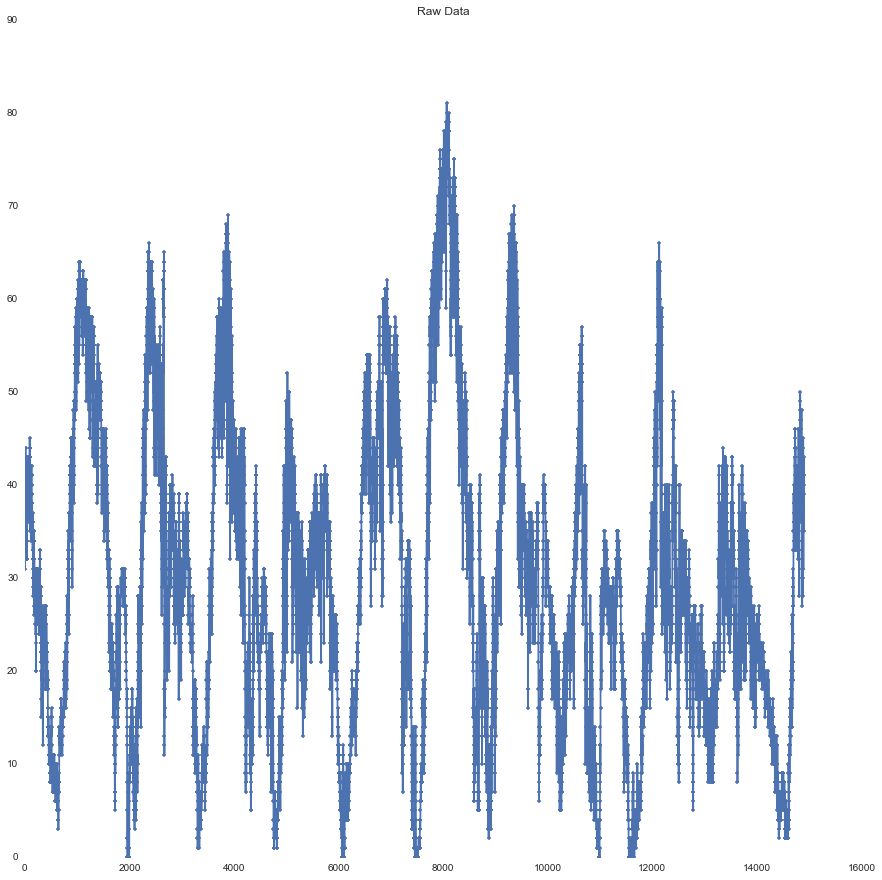

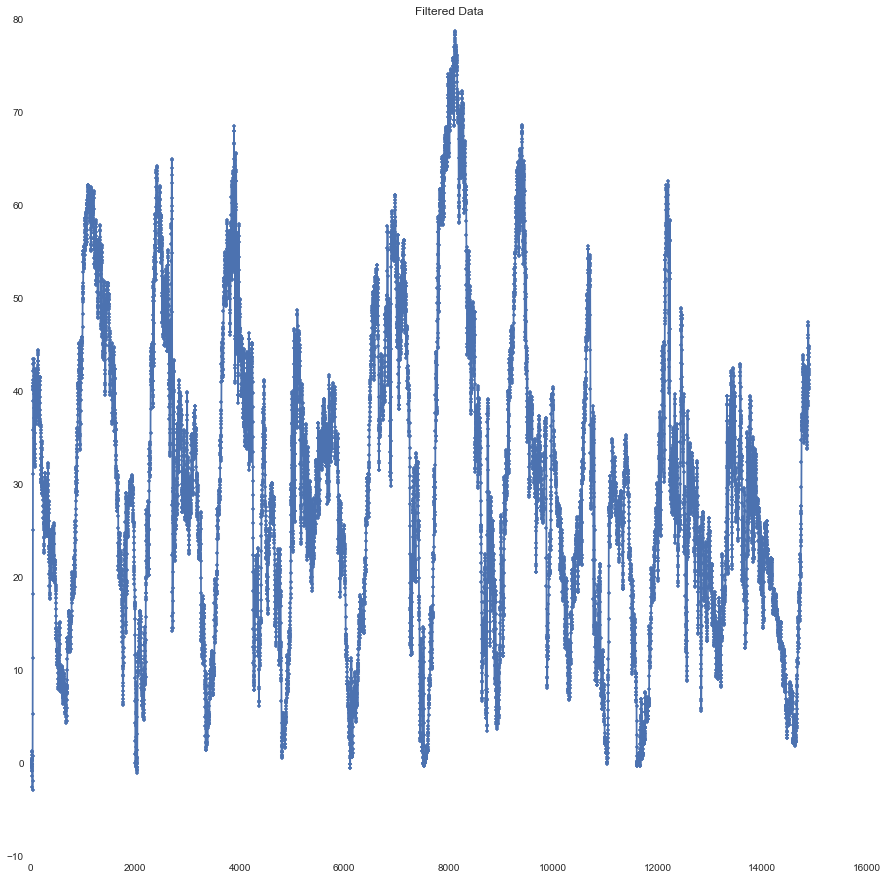

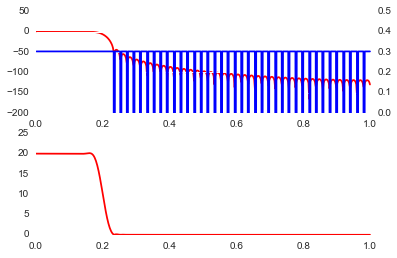

In [93]:
#Choose the number of data points in the window, and the number of minutes in the sampling period.
data_points = 100
filter_minutes = 5

ref_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['O3_ppb'].values)
print 'Reference Data'
print ref_o3_sm[:25]

#pod_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['e2v03'].values)
#print 'Pod Data'
#print pod_o3_sm[:5]

####Make a new dataframe without the offset rows, and append the new data into it.

In [94]:
df_short = df_fit.ix[data_points:]
print df_short[:5]

                     O3_ppb      UnixTime       e2v03       Temp         Rh  \
Date                                                                          
2014-07-13 02:40:00      44  1.405219e+09   96.666667  25.266667  44.966667   
2014-07-13 02:41:00      42  1.405219e+09   98.000000  25.233333  45.100000   
2014-07-13 02:42:00      40  1.405219e+09   99.000000  25.166667  45.333333   
2014-07-13 02:43:00      38  1.405219e+09  101.000000  25.100000  45.500000   
2014-07-13 02:44:00      38  1.405219e+09  102.333333  25.066667  45.666667   

                     days from start  
Date                                  
2014-07-13 02:40:00                0  
2014-07-13 02:41:00                0  
2014-07-13 02:42:00                0  
2014-07-13 02:43:00                0  
2014-07-13 02:44:00                0  


In [95]:
df_short['ref_o3_smooth'] = ref_o3_sm
#df_short['pod_o3_smooth'] = pod_o3_sm
print df_short[:25]

                     O3_ppb      UnixTime       e2v03       Temp         Rh  \
Date                                                                          
2014-07-13 02:40:00      44  1.405219e+09   96.666667  25.266667  44.966667   
2014-07-13 02:41:00      42  1.405219e+09   98.000000  25.233333  45.100000   
2014-07-13 02:42:00      40  1.405219e+09   99.000000  25.166667  45.333333   
2014-07-13 02:43:00      38  1.405219e+09  101.000000  25.100000  45.500000   
2014-07-13 02:44:00      38  1.405219e+09  102.333333  25.066667  45.666667   
2014-07-13 02:45:00      36  1.405220e+09  104.000000  25.050000  45.700000   
2014-07-13 02:46:00      35  1.405220e+09  105.000000  25.000000  45.766667   
2014-07-13 02:47:00      40  1.405220e+09  102.000000  24.933333  45.833333   
2014-07-13 02:48:00      41  1.405220e+09  101.000000  24.933333  45.900000   
2014-07-13 02:49:00      41  1.405220e+09  100.000000  24.900000  45.933333   
2014-07-13 02:50:00      40  1.405220e+09  100.00000

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipython-3.1.0-py2.7.egg/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


##Make a csv file with the smoothed data

In [96]:
df_short.to_csv(path_or_buf = 'data/D6_filt_10mino3.csv')